# File Overview

This file analyses the "choose all that apply" technology answers, 
looking for outliers by country

# Outputs / Assets

* largest_outliers by deviation table
* Microsoft product interest by country grouped bar chart

In [1]:
country_min_sample_cutoff = 1000

In [2]:
import pandas as pd
import time

pd.options.display.max_rows = 2000
pd.options.display.max_columns = 1000
pd.options.display.max_colwidth = 255

script_start = time.time()

df = pd.read_csv('./assets/survey_results_public.csv')
schema = pd.read_csv('./assets/survey_results_schema.csv')
multiple_choice_technology_columns = [
    'DatabaseDesireNextYear',
    'DatabaseWorkedWith',
    'LanguageDesireNextYear',
    'LanguageWorkedWith',
    'MiscTechDesireNextYear',
    'MiscTechWorkedWith',
    'NEWCollabToolsDesireNextYear',
    'NEWCollabToolsWorkedWith',
    'PlatformDesireNextYear',
    'PlatformWorkedWith',
    'WebframeDesireNextYear',
    'WebframeWorkedWith'
]

In [3]:
countries = df['Country'].value_counts()
countries_with_enough_samples = countries[countries > (country_min_sample_cutoff)].index.values
country_subset = df.query('Country in @countries_with_enough_samples')

In [4]:
def compute_multiple_choice_response_stats (df, mc_questions):

    questions_lookup = {}
    questions_country = {}
    answers_by_country = {}

    def vivify_question (question):
        if question not in questions_lookup:
            questions_lookup[question] = { 'question': question, 'question_response_count': 0 }

    def vivify_questions_country (question, country):
        if (question, country) not in questions_country:
            questions_country[(question, country)] = { 'question': question, 'country': country, 'question_response_country_count': 0 }

    def vivify_answer_by_country (question, answer, country):
        if (question, answer, country) not in answers_by_country:
            answers_by_country[(question, answer, country)] = { 'question': question, 'country': country, 'answer': answer, 'country_answer_count': 0 }

    def record_question_was_answered (question, country):
        vivify_question(question)
        questions_lookup[question]['question_response_count'] +=1
        vivify_questions_country(question, country)
        questions_country[(question, country)]['question_response_country_count'] += 1
        
    def record_answer (question, answer, country):
        vivify_answer_by_country(question, answer, country)
        answers_by_country[(question, answer, country)]['country_answer_count'] += 1

    def process_survey_response (response):
        country = response['Country']
        for question in mc_questions:
            answer_string = response[question]
            if answer_string != answer_string:
                None
            else:
                record_question_was_answered(question, country)
                answers = answer_string.split(';')

                for answer in answers:
                    record_answer(question, answer, country)

    df.apply(process_survey_response, axis=1)
    
    question_counts = pd.DataFrame(data=questions_lookup.values())
    question_counts_by_country = pd.DataFrame(data=questions_country.values())
    answer_counts_by_country = pd.DataFrame(data=answers_by_country.values())

    return question_counts, question_counts_by_country, answer_counts_by_country

question_counts, question_counts_by_country, answer_counts_by_country = compute_multiple_choice_response_stats(country_subset, multiple_choice_technology_columns)

In [5]:
# data set reference
# question_counts -> (question) -> question_response_count
# question_answer_counts -> (question, answer) -> answer_count
# question_counts_by_country -> (question, country) -> total question_response_country_count

# answer_counts_by_country -> (question, answer, country) -> country_answer_count

question_answer_counts = answer_counts_by_country \
    .groupby(['question', 'answer']).sum()['country_answer_count'] \
    .reset_index() \
    .rename(columns={"country_answer_count": "answer_count"}) \
    .merge(question_counts, on='question', how='left') \

question_answer_counts['answer_proportion'] = question_answer_counts['answer_count'] / question_answer_counts['question_response_count']
question_answer_counts.drop(columns=['question_response_count'], inplace = True)


In [6]:
merged = answer_counts_by_country \
  .merge(question_counts_by_country, on=['question', 'country'], how='left') \
  .merge(question_answer_counts, on=['question', 'answer'], how='left')

merged['country_answer_proportion'] = merged['country_answer_count'] / merged['question_response_country_count']
merged['country_answer_proportion_diff'] = merged['country_answer_proportion'] - merged['answer_proportion']

question_answer_proportion_stddev = merged.groupby(['question', 'answer']).std()['country_answer_proportion'].reset_index().rename(columns={ "country_answer_proportion": "answer_proportion_stddev" })

merged2 = merged.merge(question_answer_proportion_stddev, on=['question', 'answer'], how='left')
merged2['country_proportion_deviations_from_mean'] = merged2['country_answer_proportion_diff'] / merged2['answer_proportion_stddev']
merged2['country_proportion_abs_deviations_from_mean'] = merged2['country_proportion_deviations_from_mean'].abs()
merged2['question_answer_plot_key'] = merged2['question'] + merged2['answer']
merged2 = merged2[[
    'question',
    'country',
    'answer',
    'answer_count',
    'answer_proportion',
    'country_answer_count',
    'question_response_country_count',
    'country_answer_proportion',
    'country_answer_proportion_diff',
    'answer_proportion_stddev',
    'country_proportion_deviations_from_mean',
    'country_proportion_abs_deviations_from_mean'
]]

In [7]:
largest_outliers = merged2 \
    .sort_values(by='country_proportion_abs_deviations_from_mean', ascending=False) \
    .rename(columns={ 'country_proportion_deviations_from_mean' : 'deviations from mean' }) \
    [['question', 'country', 'answer', 'deviations from mean']]

largest_outliers.head(10)

,question,country,answer,deviations from mean
2528,NEWCollabToolsDesireNextYear,Russian Federation,Microsoft Teams,-3.303201
1876,MiscTechWorkedWith,Italy,Xamarin,3.150133
757,WebframeWorkedWith,France,Symfony,3.148138
530,NEWCollabToolsDesireNextYear,Brazil,Trello,3.113455
1252,LanguageWorkedWith,Italy,Assembly,3.092435
533,NEWCollabToolsWorkedWith,Brazil,Trello,2.989476
1246,PlatformWorkedWith,Italy,Arduino,2.895572
876,WebframeDesireNextYear,France,Symfony,2.887714
1247,PlatformWorkedWith,Italy,Windows,2.885916
418,DatabaseDesireNextYear,France,Elasticsearch,2.873854


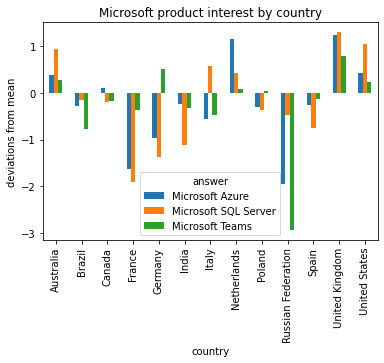

In [8]:
microsoft_sentiment_outliers = merged2 \
    .sort_values(by=['country', 'question', 'answer']) \
    .query('answer.str.contains("Microsoft")', engine='python') \
    [['question', 'country', 'answer', 'country_proportion_deviations_from_mean']] \

# TODO its not really correct to take the mean of the deviations. I am losing data here.
# but the trend is probably not lost. So Im going to leave it as is for now

microsoft_sentiment_outliers_grouped_by_tech = microsoft_sentiment_outliers \
    .groupby(['country', 'answer']).mean() \
    .rename(columns={ "country_proportion_deviations_from_mean": "deviation_from_mean" })

microsoft_sentiment_outliers_grouped_by_tech \
    .reset_index() \
    .pivot(index='country', columns=['answer'], values='deviation_from_mean') \
    .plot( \
          kind='bar', \
          title="Microsoft product interest by country", \
          ylabel="deviations from mean"
    );
